In [54]:
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
ALGORITHM = 'XG Boost'
#ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
#VERSION = '06'
VERSION = '11'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: XG Boost
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 10


In [55]:
#%pip install catboost
#%pip install lightgbm

In [56]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results



{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [57]:
#OVERRIDE_N_ITER = 5

In [58]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

In [60]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [61]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v10.csv
(46871, 59)


In [62]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__1 bedroom,...,feature__reception room,feature__separate kitchen,feature__share of freehold,feature__three bedrooms,feature__three double bedrooms,feature__top floor,feature__two bathrooms,feature__two bedrooms,feature__two double bedrooms,feature__two reception rooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,...,0,1,0,0,0,0,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,0,...,0,0,0,0,0,1,0,0,1,0
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN,0,...,0,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD,0,...,0,0,0,1,0,0,0,0,0,0
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df.isnull().sum()

Price                                    0
bedrooms                                 0
bathrooms                                0
nearestStation                           0
location.latitude                        0
location.longitude                       0
latitude_deviation                       0
longitude_deviation                      0
tenure.tenureType                     2744
feature__1 bedroom                       0
feature__2 bedrooms                      0
feature__2 double bedrooms               0
feature__allocated parking               0
feature__allocated parking space         0
feature__balcony                         0
feature__bathroom                        0
feature__chain free                      0
feature__close to local amenities        0
feature__communal garden                 0
feature__communal gardens                0
feature__double bedroom                  0
feature__double glazed                   0
feature__double glazing                  0
feature__ep

In [64]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 59 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Price                               46871 non-null  float64
 1   bedrooms                            46871 non-null  float64
 2   bathrooms                           46871 non-null  float64
 3   nearestStation                      46871 non-null  float64
 4   location.latitude                   46871 non-null  float64
 5   location.longitude                  46871 non-null  float64
 6   latitude_deviation                  46871 non-null  float64
 7   longitude_deviation                 46871 non-null  float64
 8   tenure.tenureType                   44127 non-null  object 
 9   feature__1 bedroom                  46871 non-null  int64  
 10  feature__2 bedrooms                 46871 non-null  int64  
 11  feature__2 double bedrooms    

,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__1 bedroom,46871.0,0.010838,0.103542,0.000000,0.000000,0.000000,0.000000,1.000000
feature__2 bedrooms,46871.0,0.015169,0.122402,0.000000,0.000000,0.000000,0.000000,2.000000


In [65]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__1 bedroom,46871.0,0.010838,0.103542,0.000000,0.000000,0.000000,0.000000,1.000000
feature__2 bedrooms,46871.0,0.015169,0.122402,0.000000,0.000000,0.000000,0.000000,2.000000


In [66]:
df.isna().sum()

Price                                    0
bedrooms                                 0
bathrooms                                0
nearestStation                           0
location.latitude                        0
location.longitude                       0
latitude_deviation                       0
longitude_deviation                      0
tenure.tenureType                     2744
feature__1 bedroom                       0
feature__2 bedrooms                      0
feature__2 double bedrooms               0
feature__allocated parking               0
feature__allocated parking space         0
feature__balcony                         0
feature__bathroom                        0
feature__chain free                      0
feature__close to local amenities        0
feature__communal garden                 0
feature__communal gardens                0
feature__double bedroom                  0
feature__double glazed                   0
feature__double glazing                  0
feature__ep

In [67]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__1 bedroom,feature__2 bedrooms,...,feature__reception room,feature__separate kitchen,feature__share of freehold,feature__three bedrooms,feature__three double bedrooms,feature__top floor,feature__two bathrooms,feature__two bedrooms,feature__two double bedrooms,feature__two reception rooms
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,...,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699,0.011127,0.015251,...,0.014254,0.020509,0.048428,0.059374,0.012804,0.013212,0.031976,0.072586,0.096857,0.016022
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220,0.104897,0.122737,...,0.118921,0.141735,0.214989,0.236326,0.112429,0.114182,0.176195,0.259459,0.295919,0.125561
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895,1.000000,2.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000


In [68]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
(39714, 61) (4413, 61) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39

In [69]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [70]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()

print("default_model_params:\n", default_model_params)
print("---------------------")
print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

default_model_params:
 {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'seed': 20}
---------------------
sklearn.metrics.get_scorer_names():
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_sco

In [71]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8
else:
    OVERRIDE_N_ITER = 25

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower() or True: #JH
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed and debug_mode:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 25 verbose: 2


Hyperparameters:


{'model__booster': ['gbtree', 'gblinear', 'dart'],
 'model__n_estimators': [75, 50, 125, 100, 150],
 'model__early_stopping_rounds': [None],
 'model__tree_method': ['auto', 'approx', 'hist'],
 'model__learning_rate': [None],
 'model__gamma': [None, 1, 10, 100, 1000, 10000, 100000],
 'model__max_depth': [6, 1, 3, 8],
 'model__min_child_weight': [1, 0.1, 0.5, 2, 5],
 'model__max_delta_step': [0, 0.3, 0.1, 0.01, 0.9, 2.5],
 'model__subsample': [1, 0, 0.1, 0.5],
 'model__objective': ['reg:squarederror', 'reg:squaredlogerror'],
 'model__n_jobs': [3],
 'model__verbosity': [1]}

In [72]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:
    from catboost import CatBoostRegressor, Pool

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END model__booster=dart, model__early_stopping_rounds=None, model__gamma=100000, model__learning_rate=None, model__max_delta_step=2.5, model__max_depth=6, model__min_child_weight=5, model__n_estimators=50, model__n_jobs=3, model__objective=reg:squarederror, model__subsample=0.1, model__tree_method=auto, model__verbosity=1; total time=   3.7s
[14:40:52] WARNING: ../src/learner.cc:627: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END model__booster=gblinear, model__early_stopping_rounds=None, model__gamma=10, model__learning_rate=None, model__max_delta_step=2.5, model__max_dept

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           inter...
                                                                  2.5],
                                        'model__max_depth': [6, 1, 3, 8],
                                        'model__min_child_weight': [1, 0.1, 0.5,
                                                                    2, 5],
                                        'model__n_estimators': [75, 50, 125,
                                                                100, 150],
                                        'model__n_jobs': [3],
                                        'model__objective': ['reg:squarederror',
                                                             'reg:squaredlogerror'],
                                        'model__subsample': [1, 0, 0.1, 0.5],
                                        'model__tree_method': ['auto', 'approx',
                                                               'hist'],
                                        'model__verbosity': [1]},
                   return_train_score=True, scoring='r2', verbose=2)

In [73]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [74]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)


In [75]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [76]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbosity,param_model__tree_method,param_model__subsample,param_model__objective,param_model__n_jobs,param_model__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
12,9.309589,0.816820,0.033678,0.008836,1,auto,0.5,reg:squarederror,3,150,...,0.659174,0.667770,0.662828,0.003626,1,0.798739,0.804236,0.797738,0.800237,0.002857
9,0.353667,0.042831,0.032219,0.003831,1,hist,1,reg:squarederror,3,50,...,0.652137,0.660820,0.654607,0.004424,2,0.717737,0.721172,0.716417,0.718442,0.002004
14,0.217570,0.055670,0.019172,0.008377,1,approx,1,reg:squarederror,3,50,...,0.469877,0.473847,0.470934,0.002086,3,0.473931,0.475079,0.472357,0.473789,0.001116
19,0.739354,0.045880,0.020952,0.010405,1,approx,1,reg:squarederror,3,75,...,0.469183,0.470759,0.468502,0.002175,4,0.472739,0.471119,0.470313,0.471390,0.001009
4,0.686793,0.055768,0.028706,0.015911,1,hist,0,reg:squarederror,3,75,...,0.469183,0.470759,0.468502,0.002175,5,0.472739,0.471119,0.470313,0.471390,0.001009
7,1.524508,0.234094,0.033840,0.015494,1,hist,1,reg:squaredlogerror,3,150,...,-14.202204,-14.093223,-14.170329,0.054794,6,-14.146758,-14.153330,-14.209091,-14.169727,0.027964
6,1.786237,0.357538,0.013357,0.000150,1,hist,0.5,reg:squaredlogerror,3,150,...,-14.202198,-14.093224,-14.170330,0.054795,7,-14.146763,-14.153320,-14.209093,-14.169725,0.027966
1,1.687418,0.027210,0.017884,0.006660,1,hist,0,reg:squaredlogerror,3,150,...,-14.202202,-14.093222,-14.170332,0.054797,8,-14.146767,-14.153326,-14.209094,-14.169729,0.027964
3,1.259838,0.194198,0.016997,0.002003,1,hist,0.1,reg:squaredlogerror,3,125,...,-14.333831,-14.223455,-14.301539,0.055488,9,-14.277702,-14.284343,-14.340758,-14.300934,0.028290
20,1.000081,0.145478,0.025396,0.006497,1,approx,0.1,reg:squaredlogerror,3,100,...,-14.485570,-14.373605,-14.452805,0.056280,10,-14.428662,-14.435371,-14.492561,-14.452198,0.028672


In [77]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [78]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [79]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/0.5/reg:squarederror/3/150/1/6/0/None/1...,1,0.662828,9.309589,0.033678,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/hist/1/reg:squarederror/3/50/0.5/6/0/None/10...,2,0.654607,0.353667,0.032219,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/2/1/0/None/10...,3,0.470934,0.217570,0.019172,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/approx/1/reg:squarederror/3/75/0.1/8/0.3/Non...,4,0.468502,0.739354,0.020952,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/hist/0/reg:squarederror/3/75/2/1/2.5/None/10...,5,0.468502,0.686793,0.028706,"{'model__verbosity': 1, 'model__tree_method': ..."
5,1/hist/1/reg:squaredlogerror/3/150/5/6/0.01/No...,6,-14.170329,1.524508,0.033840,"{'model__verbosity': 1, 'model__tree_method': ..."
6,1/hist/0.5/reg:squaredlogerror/3/150/1/6/0/Non...,7,-14.170330,1.786237,0.013357,"{'model__verbosity': 1, 'model__tree_method': ..."
7,1/hist/0/reg:squaredlogerror/3/150/2/1/0.01/No...,8,-14.170332,1.687418,0.017884,"{'model__verbosity': 1, 'model__tree_method': ..."
8,1/hist/0.1/reg:squaredlogerror/3/125/2/1/0/Non...,9,-14.301539,1.259838,0.016997,"{'model__verbosity': 1, 'model__tree_method': ..."
9,1/approx/0.1/reg:squaredlogerror/3/100/2/8/0.9...,10,-14.452805,1.000081,0.025396,"{'model__verbosity': 1, 'model__tree_method': ..."


In [80]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


20 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/0.5/reg:squarederror/3/150/1/6/0/None/1...,1,0.662828,9.309589,0.033678,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/hist/1/reg:squarederror/3/50/0.5/6/0/None/10...,2,0.654607,0.353667,0.032219,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/2/1/0/None/10...,3,0.470934,0.217570,0.019172,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/approx/1/reg:squarederror/3/75/0.1/8/0.3/Non...,4,0.468502,0.739354,0.020952,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/hist/0/reg:squarederror/3/75/2/1/2.5/None/10...,5,0.468502,0.686793,0.028706,"{'model__verbosity': 1, 'model__tree_method': ..."


In [81]:
#pd.set_option('display.max_columns', None)


In [82]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__verbosity,param_model__tree_method,param_model__subsample,param_model__objective,param_model__n_jobs,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,param_model__max_delta_step,param_model__learning_rate,param_model__gamma,param_model__early_stopping_rounds,param_model__booster,params,params2
12,1,0.662828,9.309589,0.033678,1,auto,0.5,reg:squarederror,3,150,1,6,0,None,100,None,gbtree,"{'model__verbosity': 1, 'model__tree_method': ...",1/auto/0.5/reg:squarederror/3/150/1/6/0/None/1...
9,2,0.654607,0.353667,0.032219,1,hist,1,reg:squarederror,3,50,0.5,6,0,None,10,None,gbtree,"{'model__verbosity': 1, 'model__tree_method': ...",1/hist/1/reg:squarederror/3/50/0.5/6/0/None/10...
14,3,0.470934,0.217570,0.019172,1,approx,1,reg:squarederror,3,50,2,1,0,None,10000,None,gbtree,"{'model__verbosity': 1, 'model__tree_method': ...",1/approx/1/reg:squarederror/3/50/2/1/0/None/10...
19,4,0.468502,0.739354,0.020952,1,approx,1,reg:squarederror,3,75,0.1,8,0.3,None,1,None,gblinear,"{'model__verbosity': 1, 'model__tree_method': ...",1/approx/1/reg:squarederror/3/75/0.1/8/0.3/Non...
4,5,0.468502,0.686793,0.028706,1,hist,0,reg:squarederror,3,75,2,1,2.5,None,10,None,gblinear,"{'model__verbosity': 1, 'model__tree_method': ...",1/hist/0/reg:squarederror/3/75/2/1/2.5/None/10...
7,6,-14.170329,1.524508,0.033840,1,hist,1,reg:squaredlogerror,3,150,5,6,0.01,None,1000,None,gblinear,"{'model__verbosity': 1, 'model__tree_method': ...",1/hist/1/reg:squaredlogerror/3/150/5/6/0.01/No...
6,7,-14.170330,1.786237,0.013357,1,hist,0.5,reg:squaredlogerror,3,150,1,6,0,None,None,None,gblinear,"{'model__verbosity': 1, 'model__tree_method': ...",1/hist/0.5/reg:squaredlogerror/3/150/1/6/0/Non...


In [83]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [84]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [85]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  12
Best Score:  0.6628282712605612
Best Params:  {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__subsample': 0.5, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 150, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': 100, 'model__early_stopping_rounds': None, 'model__booster': 'gbtree'}


In [86]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e

In [87]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [88]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.6817846640537966

In [89]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.6817846640537966
Mean Absolute Error Accuracy 46626.68757435418
Mean Squared Error Accuracy 3594689512.156493
Root Mean Squared Error 59955.72960240325


In [90]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [91]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,334352.28125,65647.71875,16.411930,19.634297
119328242,369950.0,430425.75000,60475.75000,16.347006,14.050217
125716790,350000.0,370196.31250,20196.31250,5.770375,5.455568
122440040,549000.0,529629.18750,19370.81250,3.528381,3.657429
120508103,495000.0,526981.75000,31981.75000,6.460960,6.068853
...,...,...,...,...,...
68620869,475000.0,531323.81250,56323.81250,11.857645,10.600657
85735665,575000.0,498814.03125,76185.96875,13.249734,15.273421
125706338,400000.0,342749.56250,57250.43750,14.312609,16.703285


In [92]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,460208,300208.21875,187.630137,65.233129,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,344980,222980.75000,182.771107,64.635708,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,281926,173926.46875,161.043027,61.692139,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
119684411,200000,419397,219397.59375,109.698797,52.312554,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
85536395,230000,468648,238648.50000,103.760217,50.922706,230000,2,2,0.162859,51.362150,-0.150440,0.137570,0.046020,FREEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118543331,487000,487075,75.65625,0.015535,0.015533,487000,2,1,0.533057,51.572181,-0.341719,0.072461,0.237299,FREEHOLD
122675393,425000,424940,59.96875,0.014110,0.014112,425000,2,1,0.126241,51.589680,-0.100000,0.089960,0.004420,LEASEHOLD
121530833,375000,374949,50.28125,0.013408,0.013410,375000,2,1,0.500416,51.639700,-0.129130,0.139980,0.024710,LEASEHOLD
121566617,475000,474946,53.31250,0.011224,0.011225,475000,3,2,0.878333,51.555374,0.124571,0.055654,0.228991,FREEHOLD


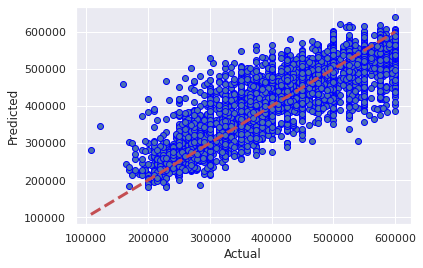

In [93]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [94]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    if showable_increment==0:showable_increment=1
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
1 ==> 1
{'model__verbosity': 1, 'model__tree_method': 'hist', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 50, 'model__min_child_weight': 0.5, 'model__max_depth': 6, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': 10, 'model__early_stopping_rounds': None, 'model__booster': 'gbtree'}
2 ==> 2
{'model__verbosity': 1, 'model__tree_method': 'approx', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 50, 'model__min_child_weight': 2, 'model__max_depth': 1, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': 10000, 'model__early_stopping_rounds': None, 'model__booster': 'gbtree'}
3 ==> 3
{'model__verbosity': 1, 'model__tree_method': 'approx', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 75, 'model__min_child_weight': 0.1, 'model__max_depth': 8, 'model__max_delta_

In [95]:
cv_results_df_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/0.5/reg:squarederror/3/150/1/6/0/None/1...,1,0.662828,9.309589,0.033678,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/hist/1/reg:squarederror/3/50/0.5/6/0/None/10...,2,0.654607,0.353667,0.032219,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/2/1/0/None/10...,3,0.470934,0.217570,0.019172,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/approx/1/reg:squarederror/3/75/0.1/8/0.3/Non...,4,0.468502,0.739354,0.020952,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/hist/0/reg:squarederror/3/75/2/1/2.5/None/10...,5,0.468502,0.686793,0.028706,"{'model__verbosity': 1, 'model__tree_method': ..."


In [96]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [97]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__verbosity': 1,
 'model__tree_method': 'auto',
 'model__subsample': 0.5,
 'model__objective': 'reg:squarederror',
 'model__n_jobs': 3,
 'model__n_estimators': 150,
 'model__min_child_weight': 1,
 'model__max_depth': 6,
 'model__max_delta_step': 0,
 'model__learning_rate': None,
 'model__gamma': 100,
 'model__early_stopping_rounds': None,
 'model__booster': 'gbtree'}

In [98]:
best_models if not_catboost else ''

{0: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'gbtree',
  'callbacks': None,
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'gamma': 100,
  'gpu_id': -1,
  'grow_policy': 'depthwise',
  'importance_type': None,
  'interaction_constraints': '',
  'learning_rate': 0.300000012,
  'max_bin': 256,
  'max_cat_to_onehot': 4,
  'max_delta_step': 0,
  'max_depth': 6,
  'max_leaves': 0,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 150,
  'n_jobs': 3,
  'num_parallel_tree': 1,
  'predictor': 'auto',
  'random_state': 20,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'sampling_method': 'uniform',
  'scale_pos_weight': 1,
  'subsample': 0.5,
  'tree_method': 'auto',
  'validate_parameters': 1,
  'verbosity': 1,
  'seed': 20},
 1: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'gbtree',
  'callbac

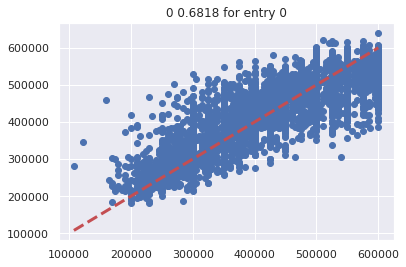

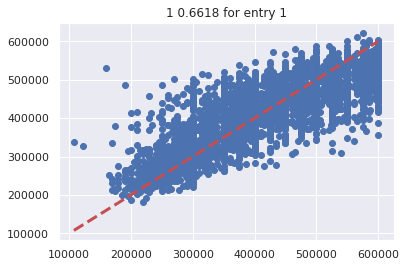

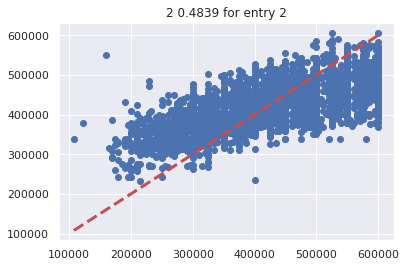

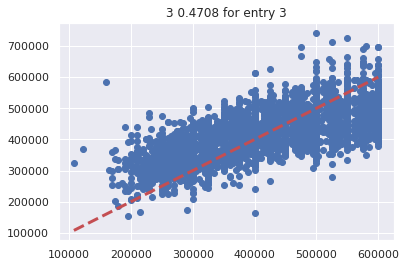

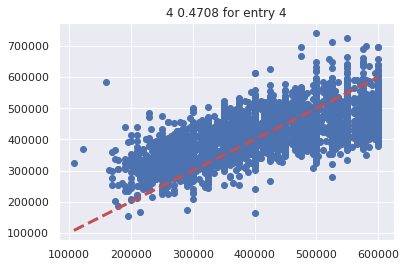

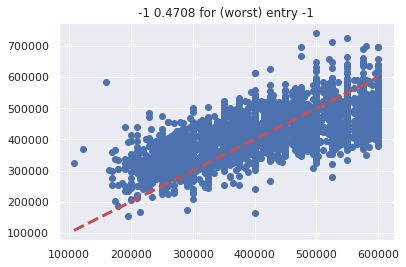

In [99]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

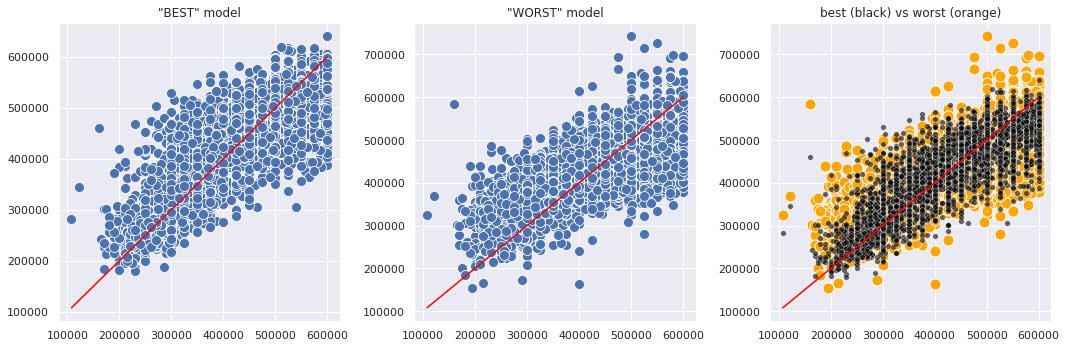

In [100]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [101]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

9.309589465459188

In [102]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

haven't scored this model yet: XG Boost
(debug:do nothing)
xg boost (v10)


In [103]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=100, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=150, n_jobs=3, num_parallel_tree=1,
                              predictor='auto', random_state=20, reg_alpha=0,
                              reg_lambda=1, ...))])

In [104]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)


pickled new version of model
0.6817846640537966 is new best score (it's better than -999)


In [105]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 59 (0.180545) tenure.tenureType_LEASEHOLD
2. features 0 (0.110706) bedrooms
3. features 1 (0.057819) bathrooms
4. features 58 (0.042226) tenure.tenureType_FREEHOLD
5. features 5 (0.033358) latitude_deviation
6. features 4 (0.030304) location.longitude
7. features 6 (0.026968) longitude_deviation
8. features 19 (0.017892) feature__double glazed
9. features 45 (0.017655) feature__private garden
10. features 3 (0.016739) location.latitude
11. features 52 (0.016415) feature__top floor
12. features 38 (0.016005) feature__no chain
13. features 30 (0.015682) feature__gas central heating
14. features 20 (0.013606) feature__double glazing
15. features 7 (0.012849) feature__1 bedroom
16. features 14 (0.012587) feature__chain free
17. features 53 (0.012187) feature__two bathrooms
18. features 57 (0.011516) tenure.tenureType_COMMONHOLD
19. features 60 (0.011514) tenure.tenureType_SHARE_OF_FREEHOLD
20. features 10 (0.011487) feature__allocated parking
21. features 48 (0

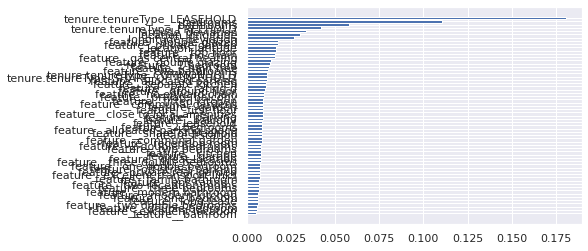

In [106]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')